In [1]:
import numpy as onp
import jax.numpy as np

from jax import lax, random
from jax.api import grad, jit, vmap
from jax.config import config
from jax.experimental import optimizers

config.update('jax_enable_x64', True)

from functools import partial
from jax import random

from neural_tangents import stax

# Attacking
from jax.experimental.stax import logsoftmax
from cleverhans.utils import clip_eta, one_hot

# Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *
sns.set_style(style='white')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

"""
diag_reg:
    a scalar representing the strength of the diagonal regularization for
    `k_train_train`, i.e. computing `k_train_train + diag_reg * I` during
    Cholesky factorization or eigendecomposition.
"""
diag_reg = 1e-4
batch_size = 30

In [2]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset('mnist', None, None, 
                                                                                  do_flatten_and_normalize=False))

In [3]:
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [4]:
train_size = 256
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]

test_size = 256
x_test = x_test_all[:test_size]
y_test = y_test_all[:test_size]

shape = (x_train.shape[0], 32, 32, 3)

In [5]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Objective - Matrix

In [6]:
def accuracy(mean, ys):
    return np.mean(np.argmax(mean, axis=-1) == np.argmax(ys, axis=-1))

In [7]:
def DenseBlock(neurons, W_std, b_std):
    return stax.serial(stax.Dense(neurons, W_std, b_std), 
                       stax.Erf())

def DenseGroup(n, neurons, W_std, b_std):
    blocks = []
    for _ in range(n):
        blocks += [DenseBlock(neurons, W_std, b_std)]
    return stax.serial(*blocks)

In [8]:
def model_fn(kernel_fn, obj_fn, x_train=None, x_test=None, fx_train_0=0., fx_test_0=0., t=None):
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    
    if obj_fn == 'train':
        return ntk_train_train
    elif obj_fn == 'test':
        ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
        # Prediction
        predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # no convariance
        return predict_fn(t, fx_train_0, fx_test_0, ntk_test_train) # fx_train_0, fx_test_0 = (0, 0) for infinite width
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

In [9]:
@jit
def l2_loss_v1(logits, labels, weighting=1):
    """
    Tensorflow version of L2 loss (without sqrt)
    """
    return np.sum(((logits - labels)**2) * weighting) / 2
    
@jit
def l2_loss_v2(logits, lables):
    """
    Normal L2 loss
    """
    return np.linalg.norm(logits - labels)

@jit
def cross_entropy_loss(logits, lables):
    return -np.sum(logsoftmax(logits) * lables)
    
@jit
def mse_loss(logits, lables):
    return 0.5 * np.mean((logits - lables) ** 2)

In [10]:
def train_loss_adv(x_train, y, kernel_fn, weighting):
    # Compute NTK on training data
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    loss = - l2_loss_v1(ntk_train_train, y, weighting) # y = matrix of 1 / diagnal
    return loss

# train_grads_fn = grad(train_loss_adv)
train_grads_fn = jit(grad(train_loss_adv), static_argnums=(2,)) # static arg: expanding {if / else} loops for graph mode

In [26]:
def test_loss_adv_matrix(x_train, x_test, kernel_fn, c, t=None):
    # Kernel -> matrix of constant c
    # assert type(c) == int
    
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Θ(test, train)Θ(train, train)^-1
    def inv(k):
        #inverse with diag_reg
        return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))
    
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, inv(ntk_train_train))
    
    # Loss
    loss = - l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
    return loss

test_grads_fn = jit(grad(test_loss_adv_matrix, argnums=0), static_argnums=(2,))
test_c_grads_fn = jit(grad(test_loss_adv_matrix, argnums=3), static_argnums=(2,))

In [12]:
def test_pred_loss_adv(x_train, x_test, y_train, y, kernel_fn, loss='mse', t=None):
    """ update {Kernel_M,N x Kernel_N,N x (dynamic of t)} """
    
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Prediction
    predict_fn = nt.predict.gradient_descent_mse(ntk_train_train, y_train, diag_reg=diag_reg) # diag_reg: add to easier inverse
    fx = predict_fn(t, 0., 0., ntk_test_train)[1]
    
    # Loss
    if loss == 'cross-entropy':
        loss = cross_entropy_loss(fx, y)
    elif loss == 'mse':
        loss = mse_loss(fx, y)
    return loss

test_pred_grads_fn = jit(grad(test_pred_loss_adv, argnums=0), static_argnums=(4, 5))

In [13]:
def fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn=None, x_train=None, y_train=None, x_test=None, 
                         y=None, t=None, c=None, update_c=False, loss='cross-entropy', loss_weighting=None, phase=None, 
                         fx_train_0=0., fx_test_0=0., eps=0.3, norm=np.inf, clip_min=None, clip_max=None, targeted=False):
    """
    JAX implementation of the Fast Gradient Method.
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with one-hot true labels. If targeted is true, then provide the
            target one-hot label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None. This argument does not have
            to be a binary one-hot label (e.g., [0, 1, 0, 0]), it can be floating points values
            that sum up to 1 (e.g., [0.05, 0.85, 0.05, 0.05]).
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
    # Obtain y
    if obj_fn == 'test':
        if y is None:
            # Using model predictions as ground truth to avoid label leaking
            x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_test, fx_train_0, fx_test_0)[1], 1)
            y = one_hot(x_labels, 10)
            
    elif obj_fn == 'train':
        if y is None:
            # Compute NTK on training data
            ntk_train_train = model_fn(kernel_fn=kernel_fn, obj_fn='train', x_train=x_train)
            
            # Construct diagonal
            if phase == 'ordered':
                y = np.ones(ntk_train_train.shape)*100
            elif phase == 'chaotic':
                y = np.eye(ntk_train_train.shape[0])*100
            else:
                raise ValueError("Phase must be either 'ordered' or 'critical'")
    
    # Obtain gradient
    # Obj - Θ(train, train)
    if obj_fn == 'train':
        grads = grads_fn(x_train, y, kernel_fn, loss_weighting)
        
    # Obj - Θ(test, train)Θ(train, train)^-1
    elif obj_fn == 'test_c':
        grads = 0
        grads_c = 0
        for i in range(int(len(x_test)/batch_size)):
            grads += grads_fn(x_train, x_test[batch_size*i:batch_size*(i+1)], kernel_fn, c, t)
            if update_c is True:
                grads_c += grads_c_fn(x_train, x_test[batch_size*i:batch_size*(i+1)], kernel_fn, c, t)
                
        grads_c = 3e-6 * np.sign(grads_c) # grads_c = 5e-2 * np.sign(grads_c)
        
        
    # Obj - Θ(test, train)Θ(train, train)^-1 y_train
    elif obj_fn == 'test':
        grads = 0
        for i in range(int(len(x_test)/batch_size)):
            batch_grads = grads_fn(x_train, 
                                   x_test[batch_size*i:batch_size*(i+1)], 
                                   y_train, 
                                   y[batch_size*i:batch_size*(i+1)], 
                                   kernel_fn, 
                                   loss,
                                   t)
            grads += batch_grads
    else:
        raise ValueError("Objective function must be either train(ntk_train_train) or test(predict_fn)")

    axis = list(range(1, len(grads.shape)))
    eps_div = 1e-12
    
    if norm == np.inf:
        perturbation = eps * np.sign(grads)
    elif norm == 1:
        raise NotImplementedError("L_1 norm has not been implemented yet.")
    elif norm == 2:
        square = np.maximum(eps_div, np.sum(np.square(grads), axis=axis, keepdims=True))
        perturbation = grads / np.sqrt(square)
    
    adv_x = x + perturbation
    
    # If clipping is needed, reset all values outside of [clip_min, clip_max]
    if (clip_min is not None) or (clip_max is not None):
        # We don't currently support one-sided clipping
        assert clip_min is not None and clip_max is not None
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
    
    if obj_fn == 'test_c':
        c += grads_c
        
        return adv_x, c
    
    return adv_x

In [14]:
def projected_gradient_descent(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn=None, x_train=None, y_train=None,
                               x_test=None, y=None, t=None, c=None, update_c=None, loss='cross-entropy', loss_weighting=None, 
                               phase=None, fx_train_0=0., fx_test_0=0., eps=0.3, eps_iter=0.03, nb_iter=10, norm=np.inf, 
                               clip_min=None, clip_max=None, targeted=False, rand_init=None, rand_minmax=0.3):
    """
    This class implements either the Basic Iterative Method
    (Kurakin et al. 2016) when rand_init is set to 0. or the
    Madry et al. (2017) method when rand_minmax is larger than 0.
    Paper link (Kurakin et al. 2016): https://arxiv.org/pdf/1607.02533.pdf
    Paper link (Madry et al. 2017): https://arxiv.org/pdf/1706.06083.pdf
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
    :param eps_iter: step size for each attack iteration
    :param nb_iter: Number of attack iterations.
    :param norm: Order of the norm (mimics NumPy). Possible values: np.inf or 2.
    :param clip_min: (optional) float. Minimum float value for adversarial example components.
    :param clip_max: (optional) float. Maximum float value for adversarial example components.
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
            target label. Otherwise, only provide this parameter if you'd like to use true
            labels when crafting adversarial samples. Otherwise, model predictions are used
            as labels to avoid the "label leaking" effect (explained in this paper:
            https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
            Untargeted, the default, will try to make the label incorrect.
            Targeted will instead try to move in the direction of being more like y.
    :return: a tensor for the adversarial example
    """

    assert eps_iter <= eps, (eps_iter, eps)
    if norm == 1:
        raise NotImplementedError("It's not clear that FGM is a good inner loop"
                                  " step for PGD when norm=1, because norm=1 FGM "
                                  " changes only one pixel at a time. We need "
                                  " to rigorously test a strong norm=1 PGD "
                                  "before enabling this feature.")
    if norm not in [np.inf, 2]:
        raise ValueError("Norm order must be either np.inf or 2.")
        
    x = x_test
    # Obtain y
    if obj_fn == 'test':
        if y is None:
            # Using model predictions as ground truth to avoid label leaking
            x_labels = np.argmax(model_fn(kernel_fn, 'test', x_train, x_test, fx_train_0, fx_test_0)[1], 1)
            y = one_hot(x_labels, 10)
            
    elif obj_fn == 'train':
        if y is None:
            # Compute NTK on training data
            ntk_train_train = model_fn(kernel_fn=kernel_fn, obj_fn='train', x_train=x_train)
            
            # Construct diagonal
            if phase == 'ordered':
                y = np.ones(ntk_train_train.shape)*100
            elif phase == 'chaotic':
                y = np.eye(ntk_train_train.shape[0])*100
            else:
                raise ValueError("Phase must be either 'ordered' or 'critical'")
        
    # Initialize loop variables
    if rand_init:
        rand_minmax = eps
        eta = random.uniform(new_key, x.shape, minval=-rand_minmax, maxval=rand_minmax)
    else:
        eta = np.zeros_like(x)

    # Clip eta
    eta = clip_eta(eta, norm, eps)
    adv_x = x + eta
    if clip_min is not None or clip_max is not None:
        adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)
        
    for i in range(nb_iter):
        if update_c is not None and (i+1) % update_c == 0:
            adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn, x_train, y_train, adv_x, 
                                         y, t, c, True, loss, loss_weighting, phase, fx_train_0, fx_test_0, eps_iter, norm, 
                                         clip_min, clip_max, targeted)
        else:
            adv_x = fast_gradient_method(model_fn, kernel_fn, obj_fn, grads_fn, grads_c_fn, x_train, y_train, adv_x, 
                                         y, t, c, False, loss, loss_weighting, phase, fx_train_0, fx_test_0, eps_iter, norm, 
                                         clip_min, clip_max, targeted)
        
        if obj_fn == 'test_c':
            adv_x, c = adv_x

        # Clipping perturbation eta to norm norm ball
        eta = adv_x - x
        eta = clip_eta(eta, norm, eps)
        adv_x = x + eta

        # Redo the clipping.
        # FGM already did it, but subtracting and re-adding eta can add some
        # small numerical error.
        if clip_min is not None or clip_max is not None:
            adv_x = np.clip(adv_x, a_min=clip_min, a_max=clip_max)

    if obj_fn == 'test_c':
        return adv_x, c
    
    return adv_x

In [15]:
# b = 0.05
b = 0.18
W = [1., 1.76, 2.5]
phase_list = ['Ordered', 'Critical', 'Chaotic']
layers = np.arange(19, 100, 20)
layer = 50
num_classes = 10

kernel_list = []
fx_train_0_list = []
fx_test_0_list = []

key = random.PRNGKey(0)

b_std = np.sqrt(b)
for w in W:
    W_std = np.sqrt(w)

    init_fn, apply_fn, kernel_fn = stax.serial(DenseGroup(layer, 1024, W_std, b_std))
    
    # Inference with a single infinite width / linearized network
    apply_fn = jit(apply_fn)
    kernel_fn = jit(kernel_fn, static_argnums=(2,))
    kernel_list.append(kernel_fn)

In [16]:
# for idx, kernel_fn in enumerate(kernel_list):
#     print(phase_list[idx])
#     print(kernel_fn(x_train, x_train, 'ntk')[:4, :4])
#     print()

# Attack Hyperparameters

In [17]:
attack_type = ["Clean", "FGSM", "PGD-10", "PGD-100"]

####### MNIST #######
eps = 0.3
eps_iter_10 = 0.04
eps_iter_100 = 0.004
####### MNIST #######

####### CIFAR #######
# eps = 16/255
# eps_iter_10 = (eps/10)*1.1
# eps_iter_100 = (eps/100)*1.1
####### CIFAR #######

val_size = 1200

# x_train_all is on host device
x_val = x_train_all[train_size:train_size+val_size]
y_val = y_train_all[train_size:train_size+val_size]

# to gpu
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

# Variance

In [18]:
def mean_predictor(x_train, x_test, kernel_fn, c=None):
    """
    return Θ(test, train)Θ(train, train)^-1 and 
    || # Θ(test, train)Θ(train, train)^-1 - target ||
    
    """
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Θ(test, train)Θ(train, train)^-1
    def inv(k):
        return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, inv(ntk_train_train))
    
    if c is None:
        c = np.mean(mean_predictor)
    
    # Loss
    loss = l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
    return loss, mean_predictor

In [19]:
def mean_predictor_row_col_wise(x_train, x_test, kernel_fn, c=None, row=False, col=False):
    """
    return Θ(test, train)Θ(train, train)^-1 and 
    || # Θ(test, train)Θ(train, train)^-1 - target ||
    
    """
    if not row and not col:
        raise ValueError("at least one of row or col should be true")
    # Kernel
    ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
    ntk_test_train = kernel_fn(x_test, x_train, 'ntk')
    
    # Θ(test, train)Θ(train, train)^-1
    def inv(k):
        return np.linalg.inv(k + diag_reg * np.eye(k.shape[0]))
    mean_predictor = np.einsum('ij,jk->ik', ntk_test_train, inv(ntk_train_train))
    loss = 0.0
    if c is None:
        if row:
            c = np.mean(mean_predictor, axis=1)
            c = np.reshape(c, (1, -1))
            loss = l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c.T)
        else:
            c = np.mean(mean_predictor, axis=0)
            loss = l2_loss_v1(mean_predictor, np.ones_like(mean_predictor)*c)
    
    return loss, mean_predictor

In [32]:
def evaluate(x_train, x_test, model_fn, kernel_fn, t=None, c=0, attack_type=None):
    y_train_predict, y_test_predict = model_fn(kernel_fn, 'test', x_train, x_test, t=t)
    print(len(y_test_predict))
    acc = accuracy(y_test_predict, y_test)
    print("Robustness({:s}): {:.2f}".format(attack_type, acc))
    
    # Mean predictor
    l, m = mean_predictor(x_train, x_test, kernel_fn, c)
    # print("c:{:.8f}, Mean: {:.8f}, Loss: {:.8f}".format(c_list[idx], np.mean(m), l))
    print(m[:5, :5])
    print()
    print('shape: ', m.shape)
    print('mat: ', np.std(m))
    print('row: ', np.mean(np.std(m, axis=0)))
    print('col: ', np.mean(np.std(m, axis=1)))
    return np.mean(m)

# train list gen

In [33]:
t = None
loss_type = ['cross-entropy', 'mse']

In [22]:
x_test_list = []
c_list = []

c_sample = evaluate(x_train, x_test, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=0, attack_type='Clean')
x_test_list.append(x_test)

256
Robustness(Clean): 0.86
[[ 0.00112736  0.01011385  0.00287164  0.001241    0.00544948]
 [-0.0015968   0.00132874  0.01696907 -0.00243109 -0.00083482]
 [-0.00199748  0.01193599 -0.00562409 -0.00149281  0.00288802]
 [-0.00396522  0.012832    0.0027059  -0.00103998  0.00695626]
 [ 0.04279609 -0.00182015 -0.00166272 -0.00105851 -0.00062796]]

shape:  (256, 256)
mat:  0.014842840670167338
row:  0.013633210044645383
col:  0.014114156922545015


In [36]:
c = c_sample.reshape((1,1))

In [37]:
c

DeviceArray([[0.00387535]], dtype=float64)

In [39]:
for _ in range(1):
    x_test_list = []
    c_list = []
    
    evaluate(x_train, x_test, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=0, attack_type='Clean')
    x_test_list.append(x_test)
    c_list.append(c)

    # FGSM
    adv_x, c = fast_gradient_method(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                    grads_fn=test_grads_fn, grads_c_fn=test_grads_fn,
                                    x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c,
                                    loss=loss_type[0], eps=eps, clip_min=0, clip_max=1)
    
    evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='FGSM')
    x_test_list.append(adv_x)
    c_list.append(c)
    
    # PGD 10
    key, new_key = random.split(key)
    c = c_sample.reshape((1,1))
    adv_x, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                          grads_fn=test_grads_fn, grads_c_fn=test_c_grads_fn, x_train=x_train, 
                                          y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=3, 
                                          loss=loss_type[0], eps=eps, eps_iter=eps_iter_10, nb_iter=10, 
                                          clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)
    
    
    evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='PGD-10')
    x_test_list.append(adv_x)
    c_list.append(c)
    
    # PGD 100
    key, new_key = random.split(key)
    c = c_sample.reshape((1,1))
    adv_x, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                          grads_fn=test_grads_fn, grads_c_fn=test_c_grads_fn,
                                          x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=3, 
                                          loss=loss_type[0], eps=eps, eps_iter=eps_iter_100, nb_iter=100, 
                                          clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)
    
    evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='PGD-100')
    x_test_list.append(adv_x)
    c_list.append(c)

256
Robustness(Clean): 0.86
[[ 0.00112736  0.01011385  0.00287164  0.001241    0.00544948]
 [-0.0015968   0.00132874  0.01696907 -0.00243109 -0.00083482]
 [-0.00199748  0.01193599 -0.00562409 -0.00149281  0.00288802]
 [-0.00396522  0.012832    0.0027059  -0.00103998  0.00695626]
 [ 0.04279609 -0.00182015 -0.00166272 -0.00105851 -0.00062796]]

shape:  (256, 256)
mat:  0.014842840670167338
row:  0.013633210044645383
col:  0.014114156922545015
256
Robustness(FGSM): 0.76
[[-7.31078699e-04  2.92903614e-03  5.43250651e-03  6.67594540e-04
   2.25524591e-03]
 [-1.96649544e-03 -8.66053704e-04  1.40917228e-02 -1.44332758e-03
  -1.68834972e-03]
 [-1.60995693e-03  8.38280497e-03 -1.84292881e-03 -2.41019468e-03
   3.41287823e-03]
 [-9.78804255e-04  1.15932265e-02  6.06483282e-03 -3.99598156e-03
   6.17756399e-03]
 [ 2.24459080e-02  5.36157801e-05 -2.52951109e-03 -2.44209142e-03
  -3.94823496e-03]]

shape:  (256, 256)
mat:  0.009387926182652663
row:  0.008874616558148524
col:  0.009327391168835113
2

In [43]:
import matplotlib.pyplot as plt

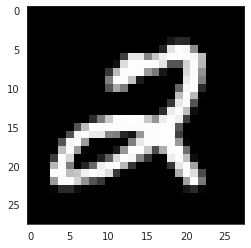

In [40]:
plt.imshow(x_test_list[0][0].reshape((28 ,28)), cmap='gray', vmin=0, vmax=1)

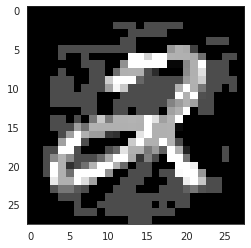

In [41]:
plt.imshow(x_test_list[1][0].reshape((28, 28)), cmap='gray', vmin=0, vmax=1)

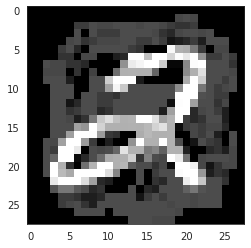

In [42]:
plt.imshow(x_test_list[2][0].reshape((28, 28)), cmap='gray', vmin=0, vmax=1)

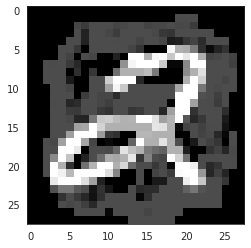

In [43]:
plt.imshow(x_test_list[3][0].reshape((28, 28)), cmap='gray', vmin=0, vmax=1)

In [76]:
t = None
c = np.zeros((1, train_size)) + 0.00387526
update_c_list = [1, 2, 4, 8, 16, 32, 64]
loss_type = ['cross-entropy', 'mse']

x_test_list = []
c_list = []
    

# Clean    
evaluate(x_train, x_test, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=0, attack_type='Clean')
x_test_list.append(x_test)
c_list.append(c)


# FGSM
adv_x, c = fast_gradient_method(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c,
                                loss=loss_type[0], eps=eps, clip_min=0, clip_max=1)

evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='FGSM')
x_test_list.append(adv_x)
c_list.append(c)

for update_c in update_c_list:
    # PGD 10
    print('update_c:', update_c)
    key, new_key = random.split(key)
    c = np.zeros((1, train_size)) + 0.00387526
    adv_x, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                          grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                          x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=update_c, 
                                          loss=loss_type[0], eps=eps, eps_iter=eps_iter_10, nb_iter=10, 
                                          clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)
    
    evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='PGD-10')
    x_test_list.append(adv_x)
    c_list.append(c)

for update_c in update_c_list:
    # PGD 100
    print('update_c:', update_c)
    key, new_key = random.split(key)
    c = np.zeros((1, train_size)) + 0.00387526
    adv_x, c = projected_gradient_descent(model_fn=model_fn, kernel_fn=kernel_list[1], obj_fn='test_c', 
                                          grads_fn=test_col_wise_grads_fn, grads_c_fn=test_col_wise_c_grads_fn,
                                          x_train=x_train, y_train=y_train, x_test=x_test, y=y_test, t=t, c=c, update_c=update_c, 
                                          loss=loss_type[0], eps=eps, eps_iter=eps_iter_100, nb_iter=100, 
                                          clip_min=0, clip_max=1, rand_init=None, rand_minmax=eps)
    
    evaluate(x_train, adv_x, model_fn=model_fn, kernel_fn=kernel_list[1], t=t, c=c, attack_type='PGD-100')
    x_test_list.append(adv_x)
    c_list.append(c)

256
Robustness(Clean): 0.86
[[ 0.00112736  0.01011385  0.00287164  0.001241    0.00544948]
 [-0.0015968   0.00132874  0.01696907 -0.00243109 -0.00083482]
 [-0.00199748  0.01193599 -0.00562409 -0.00149281  0.00288802]
 [-0.00396522  0.012832    0.0027059  -0.00103998  0.00695626]
 [ 0.04279609 -0.00182015 -0.00166272 -0.00105851 -0.00062796]]

256
Robustness(FGSM): 0.76
[[-7.31078699e-04  2.92903614e-03  5.43250651e-03  6.67594540e-04
   2.25524591e-03]
 [-1.96649544e-03 -8.66053704e-04  1.40917228e-02 -1.44332758e-03
  -1.68834972e-03]
 [-1.60995693e-03  8.38280497e-03 -1.84292881e-03 -2.41019468e-03
   3.41287823e-03]
 [-9.78804255e-04  1.15932265e-02  6.06483282e-03 -3.99598156e-03
   6.17756399e-03]
 [ 2.24459080e-02  5.36157801e-05 -2.52951109e-03 -2.44209142e-03
  -3.94823496e-03]]

update_c: 1
256
Robustness(PGD-10): 0.78
[[-4.26988120e-03  5.04486080e-03  8.86506402e-03 -5.67124272e-05
   3.58916334e-03]
 [-2.03793332e-03 -2.66613768e-03  1.48294663e-02 -1.70671905e-03
  -1.4486